In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [6]:
# Step 1: Load and Preprocess Data
df = pd.read_csv('stock_data.csv')

In [7]:
# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()

In [8]:
# Drop rows with missing Close prices
df = df[['Close']].dropna()

In [9]:
# Step 2: Feature Engineering
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['RSI_14'] = compute_rsi(df['Close'], 14)

In [10]:
# Drop initial NaNs caused by rolling calculations
df.dropna(inplace=True)

In [11]:
# Step 3: Scale the Features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[['Close', 'SMA_20', 'RSI_14']])
df_scaled = pd.DataFrame(scaled_features, index=df.index, columns=['Close', 'SMA_20', 'RSI_14'])

In [12]:
# Step 4: Create Feature and Target Arrays
X = df_scaled[:-1].values  # Features (exclude last day)
y = df_scaled[1:].values[:, 0]    # Proper slicing for target

In [13]:
# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
# Step 6: Train the Model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [15]:
# Step 7: Make Predictions and Evaluate
y_pred = model.predict(X_test)

In [16]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [17]:
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.00047711061953841644
Root Mean Squared Error: 0.021842861981398325
R-squared: 0.9378286247062764


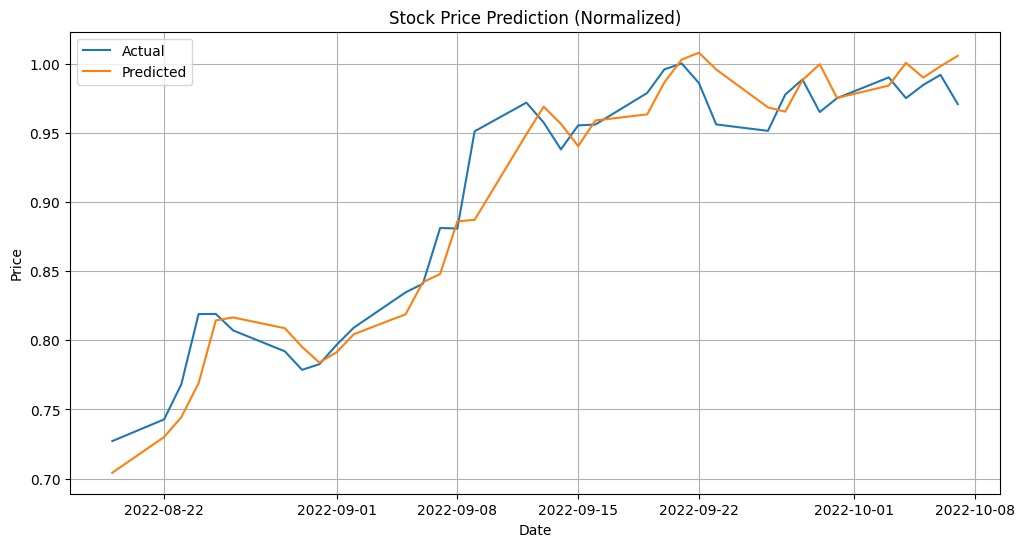

In [18]:
# Step 8: Visualize Results
plt.figure(figsize=(12, 6))
plt.plot(df_scaled.index[-len(y_test):], y_test, label='Actual')
plt.plot(df_scaled.index[-len(y_test):], y_pred, label='Predicted')
plt.title('Stock Price Prediction (Normalized)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

Extra

**1. Feature Engineering Enhancements**

*Add MACD (Moving Average Convergence Divergence)*

In [19]:
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

*Add Bollinger Bands*

In [20]:
df['MA20'] = df['Close'].rolling(window=20).mean()
df['STD20'] = df['Close'].rolling(window=20).std()
df['Upper_BB'] = df['MA20'] + (df['STD20'] * 2)
df['Lower_BB'] = df['MA20'] - (df['STD20'] * 2)

*Add Lag Features (Previous Days’ Closing Prices)*

In [21]:
df['Lag_1'] = df['Close'].shift(1)
df['Lag_2'] = df['Close'].shift(2)
df['Lag_3'] = df['Close'].shift(3)

Then drop NaN rows caused by moving averages and lagging:

In [22]:
df.dropna(inplace=True)

**2. Advanced Model Options**

*Option A: SVR (Support Vector Regression)*

In [23]:
from sklearn.svm import SVR
model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
model.fit(X_train, y_train)

SVR(C=100, epsilon=0.01, gamma=0.1)

*Option B: LSTM (Deep Learning)*

LSTM works best when input is reshaped to 3D (samples, time steps, features). Example:

In [24]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Reshape for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(1, X_train.shape[1])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, verbose=1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1611
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1095 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0750 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0572 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0371 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0259 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0206  
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0172  
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0164  
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0166 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0140 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125 
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102 
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 
Epoch 16/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms